In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [2]:
hcolumns = ['myCompany_pred','competitor1_lag_returns','competitor2_lag_returns','competitor3_lag_returns','NIFTY_lag_returns','myCompany_lr_1','myCompany_lr_2','myCompany_lr_5','myCompany_lr_10']
df = pd.DataFrame(columns = hcolumns)
df

,myCompany_pred,competitor1_lag_returns,competitor2_lag_returns,competitor3_lag_returns,NIFTY_lag_returns,myCompany_lr_1,myCompany_lr_2,myCompany_lr_5,myCompany_lr_10


In [3]:
myCompany= yf.download('ASHOKLEY.NS',start='2014-01-01')
myCompany=myCompany['Close']

comp1= yf.download('TATAMOTORS.NS',start='2014-01-01')
comp1=comp1['Close']

comp2= yf.download('MARUTI.NS',start='2014-01-01')
comp2=comp2['Close']

comp3= yf.download('M&M.NS',start='2014-01-01')
comp3=comp3['Close']

nifty= yf.download('^NSEI',start='2014-01-01')
nifty=nifty['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df['myCompany_pred']=myCompany
df['myCompany_pred'] = np.log(df['myCompany_pred']).diff()#log returns

df['competitor1_lag_returns']=comp1.shift()
df['competitor1_lag_returns'] = np.log(df['competitor1_lag_returns']).diff()

df['competitor2_lag_returns']=comp2.shift()
df['competitor2_lag_returns'] = np.log(df['competitor2_lag_returns']).diff()

df['competitor3_lag_returns']=comp3.shift()
df['competitor3_lag_returns'] = np.log(df['competitor3_lag_returns']).diff()

df['NIFTY_lag_returns']=nifty.shift()
df['NIFTY_lag_returns'] = np.log(df['NIFTY_lag_returns']).diff()

In [5]:
df['myCompany_lr_1']=df['myCompany_pred'].shift(1).dropna()
df['myCompany_lr_2']=df['myCompany_pred'].shift(2).dropna()
df['myCompany_lr_5']=df['myCompany_pred'].shift(5).dropna()
df['myCompany_lr_10']=df['myCompany_pred'].shift(10).dropna()
df=df.dropna()

In [6]:
X=df.copy()
X=X.drop(['myCompany_pred'], axis = 1)
Y = df['myCompany_pred']

In [7]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [8]:
X_train_ARIMA=X_train.loc[:, ['competitor1_lag_returns','competitor2_lag_returns','competitor3_lag_returns','NIFTY_lag_returns']]
X_test_ARIMA=X_test.loc[:, ['competitor1_lag_returns','competitor2_lag_returns','competitor3_lag_returns','NIFTY_lag_returns']]

In [9]:
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [10]:
from statsmodels.tsa.arima_model import ARIMA

In [11]:
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

C:\Users\nilay\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [12]:
predicted_tuned = model_fit_tuned.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0008996891858564458


C:\Users\nilay\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [13]:
predicted_tuned

1505   -0.015911
1506    0.009535
1507   -0.010520
1508   -0.003963
1509    0.030591
          ...   
1877    0.000705
1878    0.003503
1879    0.002639
1880   -0.002471
1881    0.007740
Length: 377, dtype: float64

In [14]:
pred=np.array(predicted_tuned)

In [15]:
compare=pd.DataFrame(columns=['Actual_returns','Predicted_returns'])
actual=Y_test
compare['Actual_returns']=actual
compare['Predicted_returns']=pred
compare

,Actual_returns,Predicted_returns
Date,,
2020-03-31,0.016394,-0.015911
2020-04-01,-0.046354,0.009535
2020-04-03,-0.074482,-0.010520
2020-04-07,0.043597,-0.003963
2020-04-08,0.095652,0.030591
...,...,...
2021-10-04,-0.006907,0.000705
2021-10-05,0.018314,0.003503
2021-10-06,-0.018314,0.002639


In [16]:
compare['trade_direction']=[1 if i>0 else -1 for i in compare['Predicted_returns']]
compare['trading_returns']=compare['trade_direction']*compare['Actual_returns']
compare

,Actual_returns,Predicted_returns,trade_direction,trading_returns
Date,,,,
2020-03-31,0.016394,-0.015911,-1,-0.016394
2020-04-01,-0.046354,0.009535,1,-0.046354
2020-04-03,-0.074482,-0.010520,-1,0.074482
2020-04-07,0.043597,-0.003963,-1,-0.043597
2020-04-08,0.095652,0.030591,1,0.095652
...,...,...,...,...
2021-10-04,-0.006907,0.000705,1,-0.006907
2021-10-05,0.018314,0.003503,1,0.018314
2021-10-06,-0.018314,0.002639,1,-0.018314


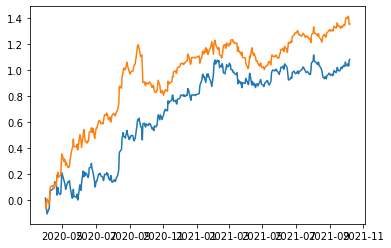

In [17]:
import matplotlib.pyplot as plt
plt.plot(compare['Actual_returns'].cumsum(), label='Buy/Hold')
plt.plot(compare['trading_returns'].cumsum(), label='Strat')


In [18]:
actual_percentage=compare['Actual_returns'].cumsum()[-1]
print(actual_percentage*100,"%")

108.33542516243853 %


In [19]:
trading_percentage=compare['trading_returns'].cumsum()[-1]
print(trading_percentage*100,"%")

135.67676436660082 %


Trading outperforms

In [20]:
qtm1= yf.download('TATAMOTORS.NS',start='2014-01-01')
qtm=qtm1['Close']
qtm=qtm.tail(5)
qmaruti1= yf.download('MARUTI.NS',start='2014-01-01')
qmaruti=qmaruti1['Close']
qmaruti=qmaruti.tail(5)
qmahindra1= yf.download('M&M.NS',start='2014-01-01')
qmahindra=qmahindra1['Close']
qmahindra=qmahindra.tail(5)
qnifty1= yf.download('^NSEI',start='2014-01-01')
qnifty=qnifty1['Close']
qnifty=qnifty.tail(5)
qcolumns = ['competitor1_lag_returns','competitor2_lag_returns','competitor3_lag_returns','NIFTY_lag_returns']
qf = pd.DataFrame(columns = qcolumns)

qf['competitor1_lag_returns']=qtm
qf['competitor1_lag_returns'] = np.log(qf['competitor1_lag_returns']).diff()

qf['competitor3_lag_returns']=qmahindra
qf['competitor3_lag_returns'] = np.log(qf['competitor3_lag_returns']).diff()

qf['competitor2_lag_returns']=qmaruti
qf['competitor2_lag_returns'] = np.log(qf['competitor2_lag_returns']).diff()

qf['NIFTY_lag_returns']=qnifty
qf['NIFTY_lag_returns'] = np.log(qf['NIFTY_lag_returns']).diff()
qf=qf.tail(1)
qf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,competitor1_lag_returns,competitor2_lag_returns,competitor3_lag_returns,NIFTY_lag_returns
Date,,,,
2021-10-08,0.019464,0.000734,0.003013,0.007691


In [21]:
X_train_ARIMA=X.loc[:, ['competitor1_lag_returns','competitor2_lag_returns','competitor3_lag_returns','NIFTY_lag_returns']]
modelARIMA_tuned=ARIMA(endog=Y,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

C:\Users\nilay\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [22]:
X_train_ARIMA = X_train_ARIMA.append(qf, ignore_index = True)
tmrw = model_fit_tuned.predict(start = 0 ,end = len(X_train_ARIMA)-1, exog = X_train_ARIMA)

C:\Users\nilay\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\nilay\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:827: SpecificationWarning: 
The number of observations in exog does not match the number of out-of-sample
observations.  This might indicate that exog is not correctly aligned. exog
should be aligned so that the exog[0] is used for the first out-of-sample
forecast, and exog[-1] is used for the last out-of-sample forecast.
exog is not used for in-sample observations which are the fitted values.

To silence this warning, ensure the number of observation in exog (1885)
matches the number of out-of-sample forecasts (1)'

  warnings.warn(msg, SpecificationWarning)


In [23]:
tmrw

0       0.004749
1       0.000717
2      -0.000805
3       0.002895
4       0.001024
          ...   
1878    0.003862
1879    0.002455
1880   -0.001360
1881    0.003670
1882    0.004935
Length: 1883, dtype: float64

In [24]:
tmrw=np.array(tmrw)
print("Expected Returns tmrw: ",tmrw[-1]*100,"%")
if(tmrw[-1]>0):
    print("BUY")
else:
    print("SELL")

Expected Returns tmrw:  0.4935003228636731 %
BUY
